# Requirements

In [ ]:
!git clone https://github.com/pr-Mais/mm_sentiment_analysis.git

In [2]:
%cd mm_sentiment_analysis

/content/mm_sentiment_analysis


In [ ]:
!pip install -r requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

%matplotlib inline
# pd.set_option('precision', 2)

In [ ]:
!mkdir data
!wget -O data/reviews_makkah_raw.csv ".."
!wget -O data/reviews_medina_raw.csv ".."

# Data exploration

In [6]:
makkah_reviews_path = './data/reviews_makkah_raw.csv'
medina_reviews_path = './data/reviews_medina_raw.csv'

paths = [makkah_reviews_path, medina_reviews_path]

import src.data as data

df = data.import_data(paths)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Imported ./data/reviews_makkah_raw.csv.
Shape: (42463, 10)
Imported ./data/reviews_medina_raw.csv.
Shape: (30770, 10)
Done importing data.
Shape: (73233, 10)


In [7]:
df.head()

,hotel_name,hotel_score,title,score,country,user_helpful_votes,review_negative,review_positive,date_reviewed,date_stayed
0,Wirgan Hotel Al Azizyah,9.1,I really enjoyed my stay,10.0,Saudi Arabia,0,nothing really,clean and new and has carpet,23 November 2022,None
1,Wirgan Hotel Al Azizyah,9.1,Recommended,9.0,Saudi Arabia,1,Everything was excellent except few trivial is...,"New, clean and spacious rooms.Taxis are availa...",19 November 2022,None
2,Wirgan Hotel Al Azizyah,9.1,Exceptional,10.0,Canada,2,Nothing,"Staff was very friendly & helpful, cleanliness...",13 November 2022,None
3,Wirgan Hotel Al Azizyah,9.1,Very good,8.0,Pakistan,0,It is little bit far from Haram,Great Hotel neat and clean,13 November 2022,None
4,Wirgan Hotel Al Azizyah,9.1,Very good,8.0,Saudi Arabia,0,None,really peaceful,12 November 2022,None


# Data preparation

This step will prepare the data set by exploring it, applying normalization where needed, and missing and duplicate value checking.

The data has been scraped from **booking.com** for English hotel reviews written during the period prior to and post COVID pendamic, for visitors of Madinah and Makkah.

## Exploring the data

In [8]:
data.check_data(df)

Checking data...
Shape:
(73233, 10)

Columns:
Index(['hotel_name', 'hotel_score', 'title', 'score', 'country',
       'user_helpful_votes', 'review_negative', 'review_positive',
       'date_reviewed', 'date_stayed'],
      dtype='object')

Number of unique values:
hotel_name              317
hotel_score              51
title                 13458
score                    35
country                 151
user_helpful_votes       10
review_negative       23854
review_positive       24521
date_reviewed          1059
date_stayed              38
dtype: int64

Number of null values:
hotel_name              0
hotel_score             0
title                   2
score                   0
country                 0
user_helpful_votes      0
review_negative       165
review_positive        14
date_reviewed           0
date_stayed             0
dtype: int64

Number of duplicated values:
1524

Done checking data.


In [9]:
# some keys in the data
negative_key = 'review_negative'
positive_key = 'review_positive'
date_key = 'date_reviewed'

df = data.prepare_data(df, positive_key, negative_key, date_key)

# TODO answer the question: what does NaN represents in this dataset?

Done cleaning data 🎉.
Shape: (26240, 4)


In [10]:
df = data.clean_data(df)

Preparing data...
Done preparing data.
[]


/content/mm_sentiment_analysis/src/data.py:97: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^\w\s]', '')


In [11]:
df.head()

,review,date,score,target
0,clean new carpet,23 November 2022,10.0,positive
1,new clean spacious roomstaxis available makka ...,19 November 2022,9.0,positive
2,staff friendly helpful cleanliness facility ni...,13 November 2022,10.0,positive
3,great hotel neat clean,13 November 2022,8.0,positive
4,really peaceful,12 November 2022,8.0,positive


TODO clean number & duplicate reviews

# Making features ready

In [12]:
df = data.encode_labels(df)

# 1 = positive, 0 = negative

Encoding labels...
Done encoding labels.


In [13]:
df.head()

,review,date,score,target
0,clean new carpet,23 November 2022,10.0,1
1,new clean spacious roomstaxis available makka ...,19 November 2022,9.0,1
2,staff friendly helpful cleanliness facility ni...,13 November 2022,10.0,1
3,great hotel neat clean,13 November 2022,8.0,1
4,really peaceful,12 November 2022,8.0,1


In [14]:
df[df.target == 1].shape

(23430, 4)

In [15]:
df[df.target == 0].shape

(2810, 4)

In [16]:
import pandas as pd

# Due to unbalance between positive and negatvie reviews, 
# we take 15% of positive reviews to balance it with negative.
reviews_pos = df[df.target == 1].sample(frac=0.12)
reviews_neg = df[df.target == 0]
df = pd.concat([reviews_pos, reviews_neg]).sample(frac=1)

# Assign features and targets
features = df.review.to_numpy()
target = df.target

In [17]:
reviews_neg.shape

(2810, 4)

In [18]:
reviews_pos.shape

(2812, 4)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, stratify=target)

In [20]:
X_train.shape

(4497,)

In [21]:
y_train.shape

(4497,)

# Machine Learning Models

## Bag of Words

In [31]:
# Testing with 2-gram and 3-gram tokens.
ngram_range = (1, 3)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer='word', ngram_range=ngram_range)

# Calculating n-grams for features & labels.
X_train_counts = count_vect.fit_transform(X_train)
train_features = (count_vect.get_feature_names_out())

X_test_counts = count_vect.transform(X_test)
test_features = (count_vect.get_feature_names_out())

In [33]:
# Checking how it looks like
pd.DataFrame(train_features, columns=['gram'])

,gram
0,000000
1,000000 do
2,000000 do many
3,01
4,01 hr
...,...
110271,zone less
110272,zone less price
110273,zones
110274,zones etc


In [35]:
pd.DataFrame(test_features, columns=['gram'])

,gram
0,000000
1,000000 do
2,000000 do many
3,01
4,01 hr
...,...
110271,zone less
110272,zone less price
110273,zones
110274,zones etc


In [34]:
X_train_counts.shape

(4497, 110276)

## TF-IDF Model

In [36]:
import numpy as np

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def visualize_features(tf_idf: np.ndarray, feats: np.ndarray):
  # Getting top ranking features
  sums = tf_idf.sum(axis = 0)

  data = []
  gram = 0

  for col, term in enumerate(feats):
      if gram == 0:
        gram = 'bigram' if len(term.split(' ')) == 2 else 'trigram'
      data.append((term, sums[0, col]))
      
  ranking = pd.DataFrame(data, columns = [gram, 'rank'])
  ranking['rank'] = normalize_data(ranking['rank'])
  words = (ranking.sort_values('rank', ascending = False))

  display(words)

In [37]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts, y_train)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [38]:
visualize_features(X_train_tfidf, train_features)

,trigram,rank
54558,location,1.000000
89936,staff,0.714810
78842,room,0.693306
40453,good,0.592228
95796,the,0.542932
...,...,...
15589,came back hotel,0.000000
100100,told multiple times,0.000000
83028,said vaccination incomplete,0.000000
83027,said vaccination,0.000000


In [39]:
from sklearn.model_selection import GridSearchCV

def train_cv(X, y, classifier, param_grid, folds):
  grid = GridSearchCV(classifier, param_grid, cv=folds, scoring='accuracy', return_train_score=False, verbose=1)
  grid_search = grid.fit(X, y)

  print(grid_search.best_params_)
  print(grid_search.best_score_)

  return grid_search.best_params_

## kNN Model

In [40]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
classifier = KNeighborsClassifier(n_jobs=-1)
k = train_cv(X_train_tfidf, y_train, classifier, param_grid, 3)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'n_neighbors': 28}
0.8245496997998666


In [41]:
knn = KNeighborsClassifier(n_neighbors=k['n_neighbors'])
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier(n_neighbors=28)

In [42]:
y_pred = knn.predict(X_test_tfidf)

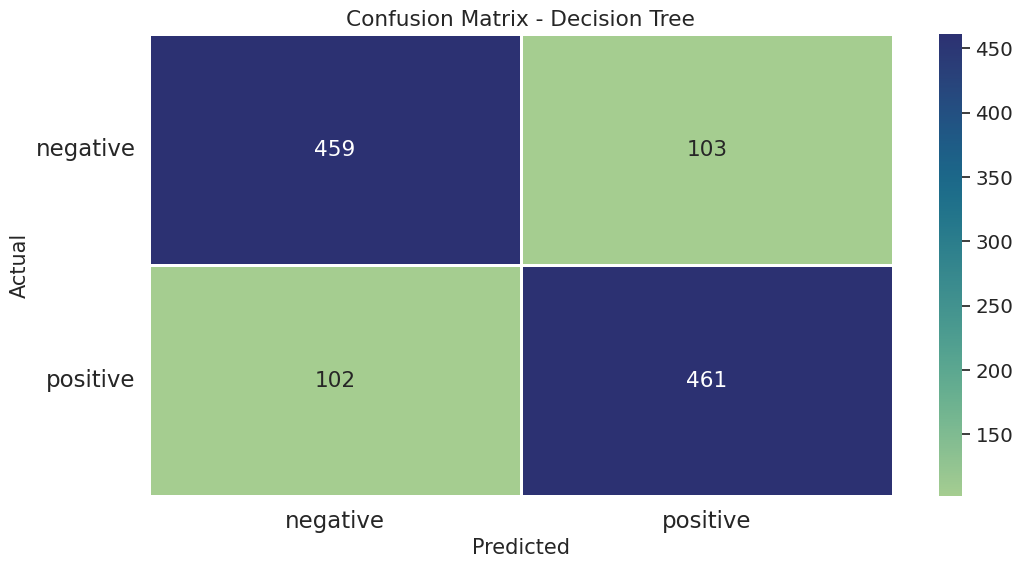

<Figure size 1000x700 with 0 Axes>

In [43]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

matrix_df = pd.DataFrame(confusion_matrix)
labelsStr = ['negative', 'positive']

ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="crest", linewidth=2)

ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted", fontsize =15)
ax.set_xticklabels(labelsStr)
ax.set_ylabel("Actual", fontsize=15)
ax.set_yticklabels(list(labelsStr), rotation = 0)
plt.show()

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       562
           1       0.82      0.82      0.82       563

    accuracy                           0.82      1125
   macro avg       0.82      0.82      0.82      1125
weighted avg       0.82      0.82      0.82      1125



In [45]:
test_sentiment = pd.DataFrame([], columns=['Review', 'Sentiment'])

for i in np.random.choice(X_test_tfidf.shape[0], 10, replace=False):
  sentiment = 'negative' if knn.predict(X_test_tfidf)[i] == 0 else 'positive'
  test_sentiment.loc[i] = [X_test[i], sentiment]

display(test_sentiment)

,Review,Sentiment
285,the carpet first room i got wet smellythe frid...,negative
519,it whole list 1 to 5 corrections changes must ...,negative
740,rooms dont intercom facilities lifts old model...,negative
1110,food smell always prevailing hotel lounge wash...,positive
860,the locationcleannice staff,positive
938,it dirty room even washroom repaired leftovers...,negative
1019,everything perfect,negative
866,wirgan aziziyah hotel nicely decorated rooms s...,positive
734,breakfast superb affordable food awesome i lik...,positive
56,everything perfect really thank,negative


In [46]:
test_sentiment.to_csv('test_sample.csv')

## RF Model

In [47]:
from sklearn.ensemble import RandomForestRegressor

param_grid = dict(n_estimators=[1000])
classifier = RandomForestRegressor(n_jobs=-1)
classifier.fit(X_train_tfidf, y_train)

RandomForestRegressor(n_jobs=-1)

In [48]:
y_pred = classifier.predict(X_test_tfidf)

In [49]:
from sklearn.metrics import accuracy_score
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       562
           1       0.83      0.87      0.85       563

    accuracy                           0.84      1125
   macro avg       0.84      0.84      0.84      1125
weighted avg       0.84      0.84      0.84      1125

0.8426666666666667


# Transformers

In [22]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [23]:
from src import utils
from src import experiment

utils.check_device()

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


device(type='cuda')

In [28]:
# First experiment with BERT
bert = experiment.TransformerExperiment(name='BERT',
                                        tokenizer=BertTokenizer.from_pretrained(
                                            'bert-base-uncased', do_lower_case=True),
                                        model=BertForSequenceClassification.from_pretrained(
                                            "bert-base-uncased",
                                            num_labels=2,
                                            output_attentions=False,
                                            output_hidden_states=False,
                                        ),
                                        X=X_train,
                                        y=y_train,
                                        batch_size=32,
                                        epochs=2)

# Second experiment with RoBERTa
roberta = experiment.TransformerExperiment(name='RoBERTa',
                                           tokenizer=RobertaTokenizer.from_pretrained(
                                               'roberta-base', do_lower_case=True),
                                           model=RobertaForSequenceClassification.from_pretrained(
                                               'cardiffnlp/twitter-roberta-base-emotion',
                                               ignore_mismatched_sizes=True,
                                               num_labels=2,
                                               output_attentions=False,
                                               output_hidden_states=False,
                                           ),
                                           X=X_train,
                                           y=y_train,
                                           batch_size=32,
                                           epochs=4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


4497
4,047 training samples
  450 validation samples
There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB

======== Epoch 1 / 2 ========
Training...
  Batch    40  of    127.    Elapsed: 0:00:27.
  Batch    80  of    127.    Elapsed: 0:00:55.
  Batch   120  of    127.    Elapsed: 0:01:22.

  Average training loss: 0.33
  Training epcoh took: 0:01:26

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    127.    Elapsed: 0:00:27.
  Batch    80  of    127.    Elapsed: 0:00:55.
  Batch   120  of    127.    Elapsed: 0:01:22.

  Average training loss: 0.18
  Training epcoh took: 0:01:26

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.33
  Validation took: 0:00:03

Training complete!
Total training took 0:02:59 (h:mm:ss)


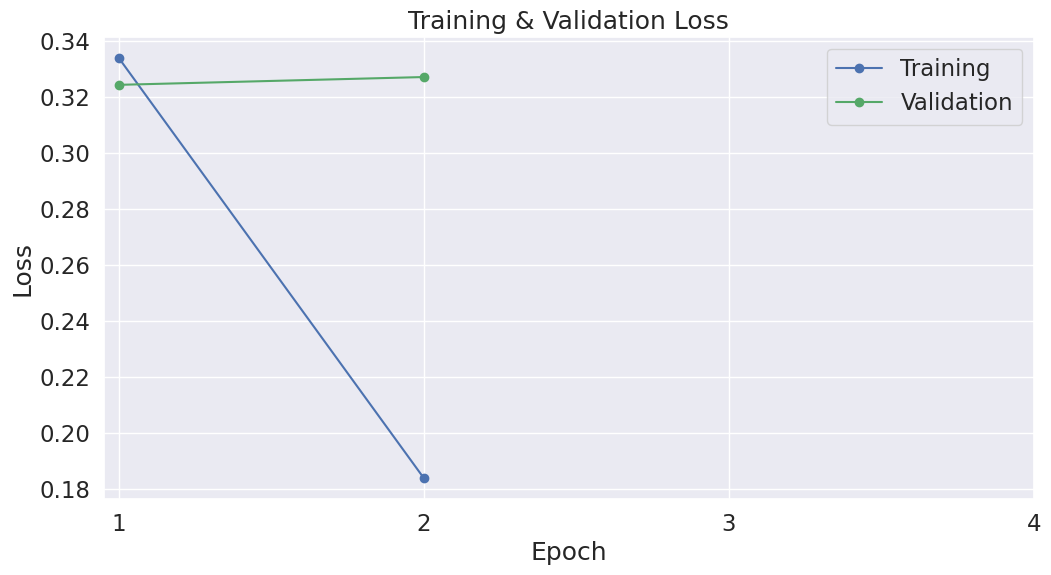

In [30]:
bert.tokenize()
bert.create_dataset()
bert.train()
bert.print_stats()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


4497
4,047 training samples
  450 validation samples
There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    127.    Elapsed: 0:00:28.
  Batch    80  of    127.    Elapsed: 0:00:56.
  Batch   120  of    127.    Elapsed: 0:01:23.

  Average training loss: 0.27
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.16
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    127.    Elapsed: 0:00:27.
  Batch    80  of    127.    Elapsed: 0:00:55.
  Batch   120  of    127.    Elapsed: 0:01:22.

  Average training loss: 0.17
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.16
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    127.    Elapsed: 0:00:27.
  Batch    80  of    127.    Elapsed: 0:00:55.
  Batch   120  of    127.    Elapsed: 0:01:22.

  Average train

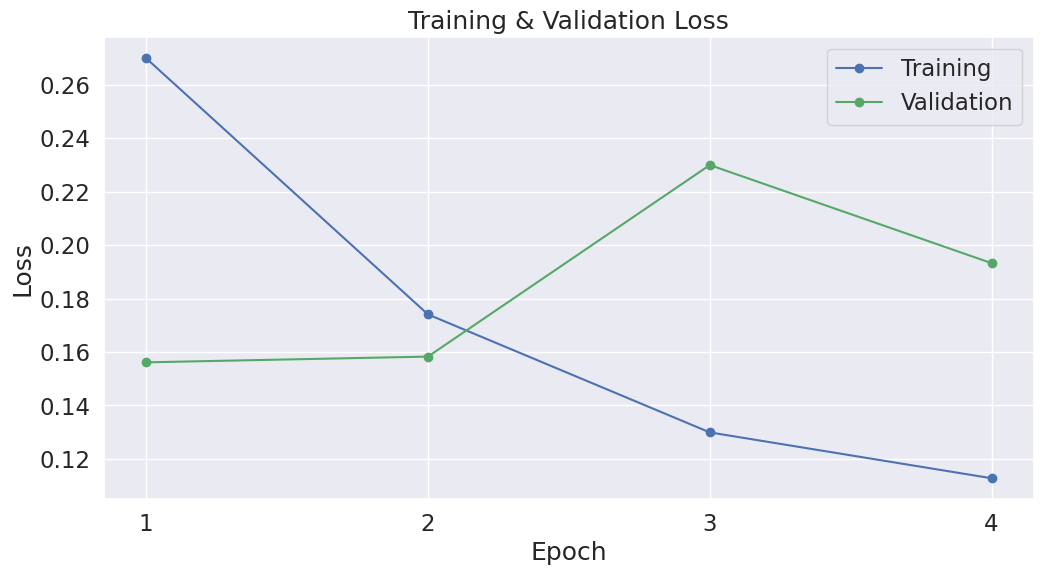

In [26]:
roberta.tokenize(max_len=512)
roberta.create_dataset()
roberta.train()
roberta.print_stats()